In [124]:
import time
from math import cos, pi, exp
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [125]:
y = 5
n_args_count = 1  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 50  # максимальный вес рыбы

##Тестовая функция Растригина

In [126]:
@njit()
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result


##Генерация начальных агентов

In [127]:
@njit()
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return result


##Реализация алгоритма

In [128]:
@njit()
def main_function():
    step_ind = list()
    step_vol = list()
    p_qbest_list = list()  # массив p_qbest в разные моменты поколений
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    step_ind.append(0.05)
    step_vol.append(0.05)
    w = list()
    w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    P = list()  # Начальная популяция
    P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list.append(p_qbest)

    f_t = list()
    f_min = f(P[t][0])
    f_t.append(f_min)
    for i in range(1, number_of_agents):
        f_I = f(P[t][i])
        if f_I < f_min:
            f_min = f_I
            p_qbest = P[t][i]
        f_t.append(f_I)

    # значение функции для каждого агента
    F = [numpy.array(f_t)]
    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        step_vol.append(step_vol[0] * exp(-y * t / iter_max))

        P.append(numpy.copy(P[t - 1]))
        w.append(numpy.copy(w[t - 1]))
        F.append(numpy.zeros(number_of_agents))
        # для каждого агента выполнить
        for i in range(number_of_agents):
            # спросить про r1 и r2, сколько в них значений
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]):
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        for i in P[t]:
            if f(p_qbest) > f(i):
                p_qbest = i
        p_qbest_list.append(p_qbest)

    return p_qbest_list

In [151]:
def draw_graphic(f_val):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title("Тестовая функция Растригина")
    plt.show()

In [129]:
start = time.time()
best_lst = main_function()
best = best_lst[-1]
end = time.time() - start
# print(*, sep='\n')
print(f'Coordinates of p_qbest:\t\t\t{best}')
print(f'The function value of pqbest:\t{f(best)}')
print(f'Algorithm running time:\t\t\t{end} s')


Coordinates of p_qbest:			[-3.55019146e-06]
The function value of pqbest:	2.500504692193317e-09
Algorithm running time:			2.7654736042022705 s


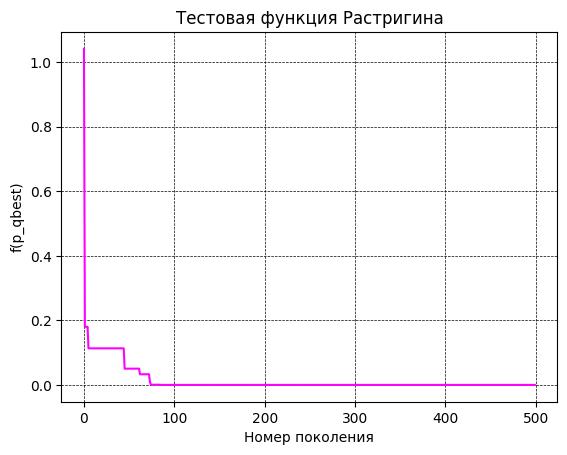

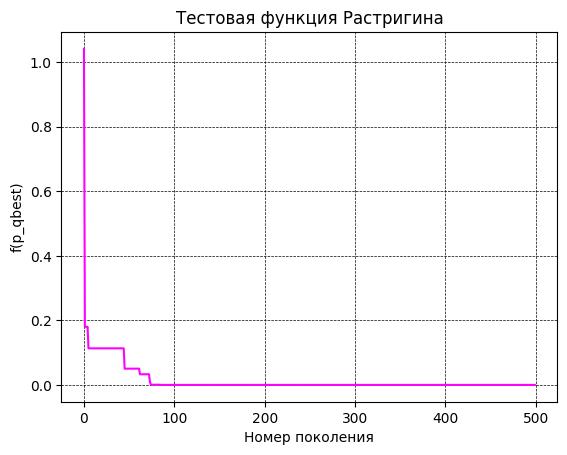

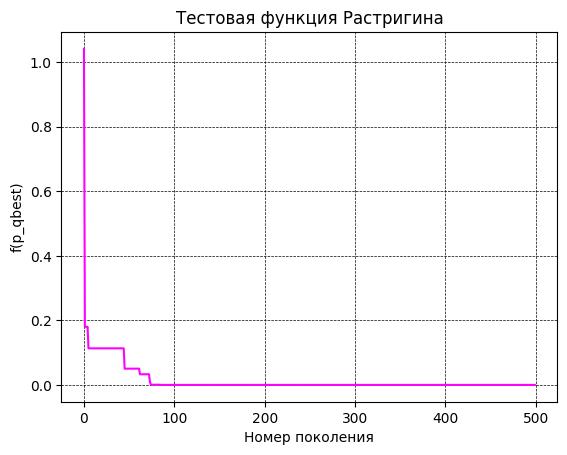

In [152]:
f_val = [f(i) for i in best_lst]
draw_graphic(f_val)
draw_graphic(f_val)
draw_graphic(f_val)